# This is going to be awesome

### Imports

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from matplotlib.colors import ListedColormap
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.patches as mpatches

In [77]:
colors = ['#BDDDFC', '#88BDF2', '#6A89A7', '#384959']
color_palett = ListedColormap(sns.color_palette(['#BDDDFC', '#AAC8E5', '#97B3CD', '#849EB6', '#71889F', '#5E7388', '#4B5E70', '#384959']))

In [78]:
pre = pd.read_csv('data/pre.csv', quotechar='\t')
during = pd.read_csv('data/during.csv', quotechar='\t')
post = pd.read_csv('data/post.csv', quotechar='\t')
pre.columns

Index(['"Timestamp', '""Participant ID (top-right corner of the screen)""',
       '""How old are you?""', '""Gender?""',
       '""What describes you the best?""',
       '""How comfortable are you in expressing emotions?""',
       '""Have you ever played with the drummer bot dB before?""',
       '""How much prior experience do you have with interactive musical interfaces (e.g. sensor systems. digital control devices)?""',
       '""How often do you use AI tools for creativity (e.g. writing. coding. music. fine arts. food recipes. etc.)?""',
       '""Please indicate if you have any of the following health problems.""";'],
      dtype='object')

### Filter data

In [79]:
# inspect for test data
mask = np.column_stack([pre[col].str.contains('test', na=False) for col in pre])
print(pre[mask])

mask = np.column_stack([pre[col].str.contains('Test', na=False) for col in pre])
print(pre[mask])

                        "Timestamp  \
0     "2024/11/04 5:15:10 PM GMT+1   
50    "2024/11/07 2:09:46 PM GMT+1   
63   "2024/11/08 12:47:28 PM GMT+1   
128  "2024/11/11 11:03:28 AM GMT+1   
131  "2024/11/11 11:29:10 AM GMT+1   
135  "2024/11/11 11:55:54 AM GMT+1   
137  "2024/11/11 12:11:12 PM GMT+1   
140  "2024/11/11 12:33:52 PM GMT+1   

    ""Participant ID (top-right corner of the screen)"" ""How old are you?""  \
0                                             ""test""                ""66""   
50                                      ""kuromitest""                ""23""   
63                                            ""test""                ""24""   
128                                   ""group8_test1""                ""25""   
131                                        ""8_test1""                ""25""   
135                                        ""8_test3""                ""22""   
137                                     ""8_testing3""                ""22""   
140              

In [80]:
## drop test data
pre = pre.drop(index=[0, 1, 63, 128, 131, 135])

In [81]:
## rename columns and remove quotes

pre_columns = pre.columns
pre_data = pre[[pre_columns[1], pre_columns[2], pre_columns[3], pre_columns[4], pre_columns[5]]]
pre_data.columns = ['Participant_ID', 'Age', 'Gender', 'Personal description', 'Comfortable with expressing emotions']
pre_data = pre_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

during_columns = during.columns
during_data = during[[during_columns[1], during_columns[2], during_columns[4], during_columns[5]]]
during_data.columns = ['Session_ID', 'Participant_ID', 'Annoyance', 'Excitement']
during_data = during_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

post_columns = post.columns
post_data = post[[post_columns[1], post_columns[3], post_columns[7]]]
post_data.columns = ['Participant_ID', 'Control', 'Creative expression']
post_data = post_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

In [82]:
## Remove participants according to the instructions
pre_data = pre_data[~pre_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]
during_data = during_data[~during_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]
post_data = post_data[~post_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]

In [83]:
## check session ID
print(during_data['Session_ID'].unique())

['ILLIAC' 'CYSP' 'VOYAGER' 'ALICE' 'Alice' 'illiac' 'voyager' 'cysp'
 'alice' '1' '3' '2' '4' 'ALLICE' 'iliac' 'ILLIAD' 'Crysp' 'Voyager'
 'Cysp' 'group18_j1_1' 'group18_j1_2' 'group18_j1_3' 'group18_j1_4'
 'Illiac' ' ALICE' 'x' ' VOYAGER']


In [84]:
## Fix session naming
during_data['Session_ID'] = during_data['Session_ID'].str.upper()
during_data['Session_ID'] = during_data['Session_ID'].replace('ALLICE', 'ALICE')
during_data['Session_ID'] = during_data['Session_ID'].replace(' ALICE', 'ALICE')
during_data['Session_ID'] = during_data['Session_ID'].replace('ILIAC', 'ILLIAC')
during_data['Session_ID'] = during_data['Session_ID'].replace('ILLIAD', 'ILLIAC')
during_data['Session_ID'] = during_data['Session_ID'].replace('CRYSP', 'CYSP')
during_data['Session_ID'] = during_data['Session_ID'].replace(' VOYAGER', 'VOYAGER')

## Delete all rows with an incorrect session name
during_data = during_data[during_data['Session_ID'].isin(['ALICE', 'ILLIAC', 'CYSP', 'VOYAGER'])]
print(during_data['Session_ID'].unique(), during_data.nunique())


# Create a pivot table to see the count of entries for each participant in each session
pivot_table = during_data.pivot_table(index='Participant_ID', columns='Session_ID', aggfunc='size', fill_value=0)

# Display the pivot table
print("Pivot table showing the count of entries for each participant in each session:")
print(pivot_table)

# Identify participants with missing data for any session
missing_participants_sessions = pivot_table[pivot_table == 0].stack().reset_index()
missing_participants_sessions.columns = ['Participant_ID', 'Session_ID', 'Count']

# Display participants with missing data for any session
print("Participants with missing data for any session:")
print(missing_participants_sessions)

# Remove participants with missing data for any session
during_data = during_data[~during_data['Participant_ID'].isin(missing_participants_sessions['Participant_ID'])]
print(during_data['Session_ID'].unique(), during_data.nunique())


['ILLIAC' 'CYSP' 'VOYAGER' 'ALICE'] Session_ID          4
Participant_ID    108
Annoyance           5
Excitement          5
dtype: int64
Pivot table showing the count of entries for each participant in each session:
Session_ID      ALICE  CYSP  ILLIAC  VOYAGER
Participant_ID                              
12345678            1     1       0        1
16_s_1              1     1       1        1
16_s_2              1     1       1        1
16_s_3              1     1       1        1
22                  1     0       0        0
...               ...   ...     ...      ...
kuromitest          1     0       0        1
pluto1              1     1       1        1
pluto2              1     1       1        1
pluto3              1     1       1        1
sigvebl             1     2       1        0

[108 rows x 4 columns]
Participants with missing data for any session:
         Participant_ID Session_ID  Count
0              12345678     ILLIAC    0.0
1                    22       CYSP    0.0
2

In [85]:
## remove duplicates if any
pre_data = pre_data.drop_duplicates(subset=['Participant_ID'], keep='first')
during_data = during_data.drop_duplicates(subset=['Participant_ID', 'Session_ID'], keep='first')
post_data = post_data.drop_duplicates(subset=['Participant_ID'], keep='first')


In [86]:
print(pre_data.shape)
print(pre_data.nunique())
print(during_data.shape)
print(during_data.nunique())
print(post_data.shape)
print(post_data.nunique())

(119, 5)
Participant_ID                          119
Age                                      28
Gender                                    2
Personal description                      5
Comfortable with expressing emotions      5
dtype: int64
(316, 4)
Session_ID         4
Participant_ID    79
Annoyance          5
Excitement         5
dtype: int64
(111, 3)
Participant_ID         111
Control                  5
Creative expression      5
dtype: int64


### Match data based on Participant ID

In [87]:
df = pre_data.merge(post_data, on='Participant_ID', how='outer', indicator=True)
only_pre = df[df['_merge'] == 'left_only']
only_post = df[df['_merge'] == 'right_only']
both = df[df['_merge'] == 'both']
print(both.shape)
both.head()

(109, 8)


,Participant_ID,Age,Gender,Personal description,Comfortable with expressing emotions,Control,Creative expression,_merge
0,andsti-01,25,Male,Avid music listener,2,1,2,both
1,andsti-02,25,Female,Student/semi-professional musician,0,1,1,both
4,Aos,11,Male,Not particularly interested in music,4,2,4,both
5,andsti-03,22,Female,Avid music listener,4,1,2,both
6,andsti-04,24,Female,Averagely interested in music,3,1,2,both


In [88]:
df_all = pd.merge(both, during_data, on='Participant_ID', how='inner')
df_all = df_all.replace(['0', '1', '2', '3', '4', '5'], [0, 1, 2, 3, 4, 5])
print(df_all.head())
df_all.nunique()

  Participant_ID Age  Gender                Personal description  \
0      andsti-01  25    Male                 Avid music listener   
1      andsti-01  25    Male                 Avid music listener   
2      andsti-01  25    Male                 Avid music listener   
3      andsti-01  25    Male                 Avid music listener   
4      andsti-02  25  Female  Student/semi-professional musician   

   Comfortable with expressing emotions  Control  Creative expression _merge  \
0                                     2        1                    2   both   
1                                     2        1                    2   both   
2                                     2        1                    2   both   
3                                     2        1                    2   both   
4                                     0        1                    1   both   

  Session_ID  Annoyance  Excitement  
0     ILLIAC          2           3  
1       CYSP          2           

Participant_ID                          79
Age                                     20
Gender                                   2
Personal description                     5
Comfortable with expressing emotions     5
Control                                  5
Creative expression                      5
_merge                                   1
Session_ID                               4
Annoyance                                5
Excitement                               5
dtype: int64

In [89]:
non_comfortable = df_all[df_all['Comfortable with expressing emotions'] < 3]
comfortable = df_all[df_all['Comfortable with expressing emotions'] >= 3]

grouped_df_all = df_all.copy()
grouped_df_all['Comfortable with expressing emotions'] = grouped_df_all['Comfortable with expressing emotions'].replace([0, 1, 2], 'Not comfortable')
grouped_df_all['Comfortable with expressing emotions'] = grouped_df_all['Comfortable with expressing emotions'].replace([3, 4], 'Comfortable')

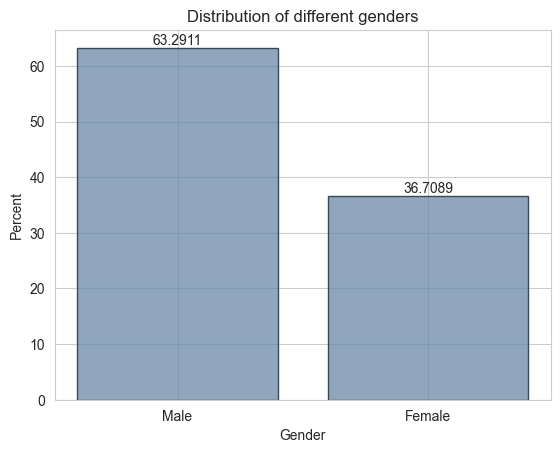

In [90]:
ax = sns.histplot(df_all['Gender'], color=colors[2], shrink=0.8, edgecolor=colors[-1], stat='percent')
ax.set_title('Distribution of different genders')
ax.bar_label(ax.containers[0])
plt.show()

In [91]:
str_numbers = [str(i) for i in range(100)]
numbers = [i for i in range(100)]
df_all['Age'] = df_all['Age'].replace(str_numbers, numbers)
m = df_all['Age'].mean()
s = df_all['Age'].std()
print(f'For the whole dataset:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')

comfortable['Age'] = comfortable['Age'].replace(str_numbers, numbers)
non_comfortable['Age'] = non_comfortable['Age'].replace(str_numbers, numbers)
m = comfortable['Age'].mean()
s = comfortable['Age'].std()
print(f'For comfortable people:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')
m = non_comfortable['Age'].mean()
s = non_comfortable['Age'].std()
print(f'For non-comfortable people:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')

For the whole dataset:
Mean: 26.823
Standard Deviation: 9.778

For comfortable people:
Mean: 25.841
Standard Deviation: 8.136

For non-comfortable people:
Mean: 28.057
Standard Deviation: 11.427



/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_34310/2969386396.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comfortable['Age'] = comfortable['Age'].replace(str_numbers, numbers)
/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_34310/2969386396.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_comfortable['Age'] = non_comfortable['Age'].replace(str_numbers, numbers)


/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_34310/1061594348.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=60)


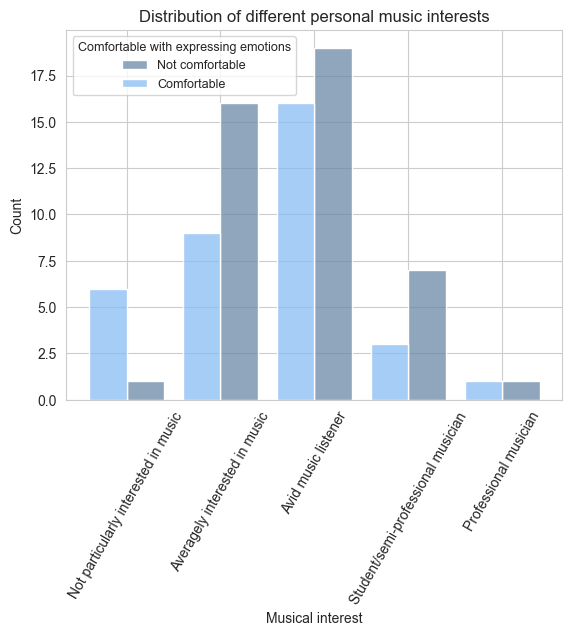

In [92]:
order = [
    'Not particularly interested in music', 
    'Averagely interested in music', 
    'Avid music listener', 
    'Student/semi-professional musician', 
    'Professional musician']

to_plot = grouped_df_all.copy()
to_plot = to_plot.drop_duplicates(subset='Participant_ID')
to_plot['Personal description'] = pd.Categorical(to_plot['Personal description'], categories=order, ordered=True)

sns.set_style('whitegrid')
ax = sns.histplot(data=to_plot, x='Personal description', hue='Comfortable with expressing emotions', palette=colors[1:3], multiple="dodge", shrink=0.8, zorder=3)
ax.set_title('Distribution of different personal music interests')
ax.set_xlabel('Musical interest')
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

<Axes: >

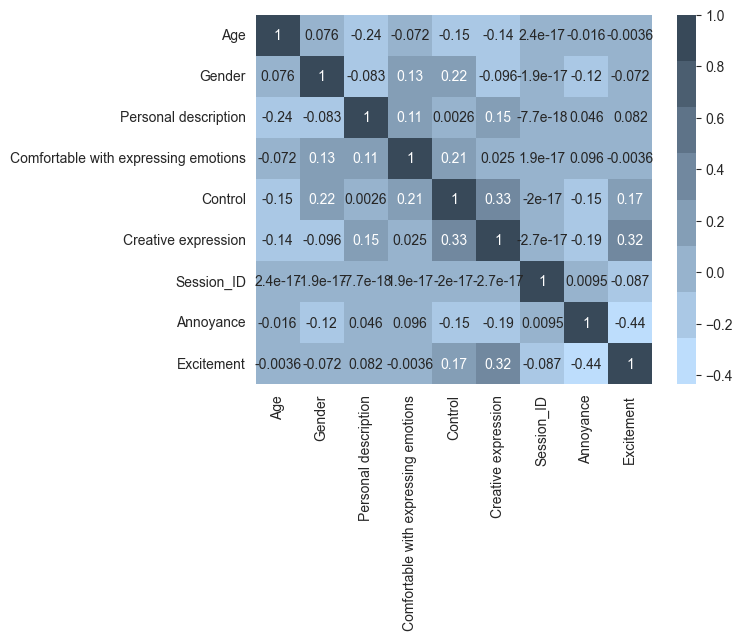

In [93]:
df_all_numeric = df_all.replace(['ILLIAC', 'CYSP', 'ALICE', 'VOYAGER'], [0, 1, 2, 3])
df_all_numeric = df_all_numeric.replace(order, [0, 1, 2, 3, 4])
df_all_numeric = df_all_numeric.replace(['Male', 'Female'], [0, 1])
df_all_numeric = df_all_numeric.drop(['Participant_ID', '_merge'], axis=1)
df_all_numeric = df_all_numeric.replace(['0', '1', '2', '3', '4', '5'], [0, 1, 2, 3, 4, 5])

sns.heatmap(df_all_numeric.corr(), annot=True, cmap=color_palett)

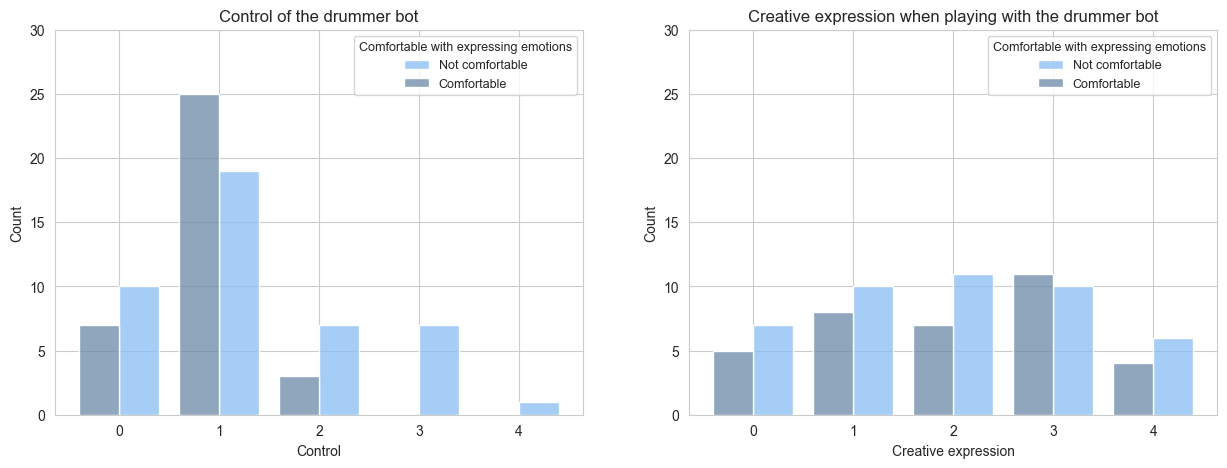

In [94]:
# Control and creative experience
to_plot = to_plot.replace([0, 1, 2, 3, 4, 5], ['0', '1', '2', '3', '4', '5'])
order = ['0', '1', '2', '3', '4', '5']
to_plot['Control'] = pd.Categorical(to_plot['Control'], categories=order, ordered=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=to_plot, x='Control', hue='Comfortable with expressing emotions', ax=axs[0], palette=[colors[2], colors[1]], multiple="dodge", shrink=0.8, zorder=3)
axs[0].set_ylim(0, 30)
axs[0].set_title('Control of the drummer bot')
axs[0].legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])

to_plot['Creative expression'] = pd.Categorical(to_plot['Creative expression'], categories=order, ordered=True)
sns.histplot(data=to_plot, x='Creative expression', hue='Comfortable with expressing emotions', ax=axs[1], palette=[colors[2], colors[1]], multiple="dodge", shrink=0.8, zorder=3)
axs[1].set_ylim(0, 30)
axs[1].set_title('Creative expression when playing with the drummer bot')
axs[1].legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])

plt.show()

/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_34310/418931352.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(


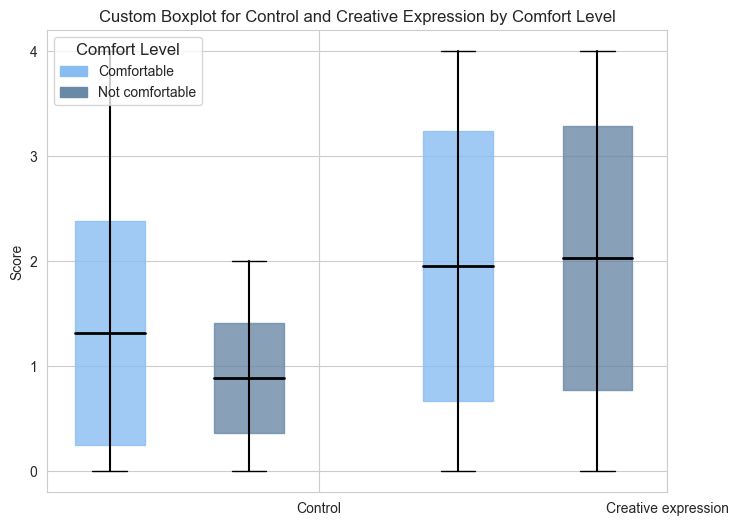

In [127]:
df_melted = pd.melt(grouped_df_all, id_vars=['Comfortable with expressing emotions'], value_vars=['Control', 'Creative expression'],
                    var_name='Variable', value_name='Value')

order = ['Comfortable', 'Not comfortable']
df_melted['Comfortable with expressing emotions'] = pd.Categorical(df_melted['Comfortable with expressing emotions'], categories=order, ordered=True)
df_melted = df_melted.sort_values('Comfortable with expressing emotions')

palette = {
    'Comfortable': colors[1],
    'Not comfortable': colors[2],
}

fig, ax = plt.subplots(figsize=(8, 6))

for idx, var in enumerate(df_melted['Variable'].unique()):
    for hue_idx, comfort in enumerate(grouped_df_all['Comfortable with expressing emotions'].unique()):
        # Get subset of data for the current variable and comfort level
        subset = df_melted[(df_melted['Variable'] == var) & (df_melted['Comfortable with expressing emotions'] == comfort)]
        
        mean = subset['Value'].mean()
        std = subset['Value'].std()
        whisker_min = subset['Value'].min()
        whisker_max = subset['Value'].max()
        
        # Position for plotting
        position = idx - (hue_idx + 0.5) * 0.4  # Adjust for hue (comfort level)

        # Plot whiskers (min and max)
        ax.plot([position, position], [whisker_min, whisker_max], color='black', lw=1.5)  # Whisker line
        ax.plot([position - 0.05, position + 0.05], [whisker_min, whisker_min], color='black', lw=1)  # Min cap
        ax.plot([position - 0.05, position + 0.05], [whisker_max, whisker_max], color='black', lw=1)  # Max cap

        # Plot the box (std around the mean)
        box_bottom = mean - std
        box_top = mean + std
        ax.add_patch(plt.Rectangle(
            (position - 0.1, box_bottom),  # Bottom-left corner
            0.2,                          # Box width
            2 * std,                      # Box height
            color=palette[comfort], alpha=0.8, edgecolor="black"
        ))

        # Plot the mean line
        ax.plot([position - 0.1, position + 0.1], [mean, mean], color="black", lw=2)  # Mean line

# Set labels and title
ax.set_xticks([0, 1])
ax.set_xticklabels(['Control', 'Creative expression'])
ax.set_yticks(range(0, 5))
ax.set_ylabel('Score')
ax.set_title('Custom Boxplot for Control and Creative Expression by Comfort Level')

legend_handles = [
    mpatches.Patch(color=colors[1], label='Comfortable'),
    mpatches.Patch(color=colors[2], label='Not comfortable')
]
ax.legend(handles=legend_handles, title='Comfort Level',
          loc='upper left', fontsize=10, title_fontsize=12)

plt.show()

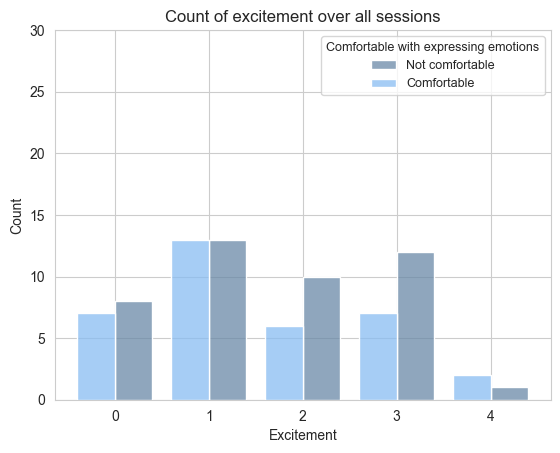

In [40]:
to_plot['Excitement'] = pd.Categorical(to_plot['Excitement'], categories=order, ordered=True)

ax = sns.histplot(data=to_plot, x='Excitement', hue='Comfortable with expressing emotions', palette=colors[1:3], multiple="dodge", shrink=0.8, zorder=3)
ax.set_title('Count of excitement over all sessions')
ax.set_xlabel('Excitement')
ax.set_ylim(0, 30)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

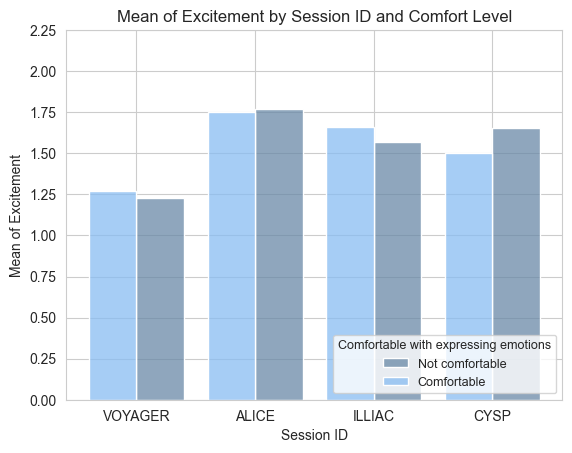

In [41]:
aggregated_data = grouped_df_all.groupby(['Session_ID', 'Comfortable with expressing emotions'], as_index=False)['Excitement'].mean()

order = ['VOYAGER', 'ALICE', 'ILLIAC', 'CYSP']
aggregated_data['Session_ID'] = pd.Categorical(aggregated_data['Session_ID'], categories=order, ordered=True)

sns.set_style('whitegrid')
ax = sns.histplot(data=aggregated_data, x='Session_ID', weights='Excitement', hue='Comfortable with expressing emotions', discrete=True, multiple='dodge', palette=colors[1:3], shrink=0.8)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'], loc='lower right')
ax.set_ylabel("Mean of Excitement")
ax.set_xlabel("Session ID")
ax.set_title("Mean of Excitement by Session ID and Comfort Level")
ax.set_ylim(0, 2.25)
plt.show()


/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_34310/559694247.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(


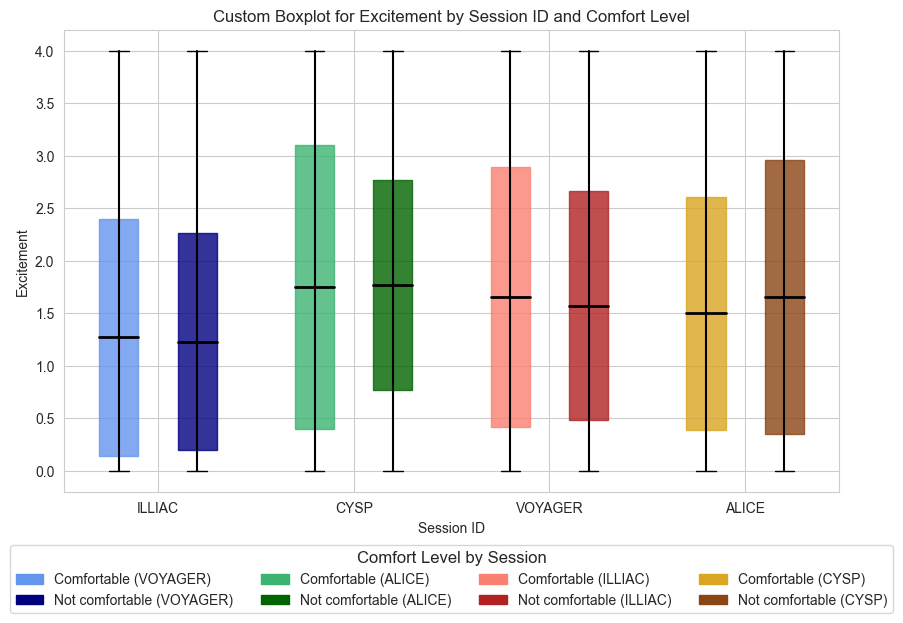

In [42]:
stats = grouped_df_all.groupby(['Session_ID', 'Comfortable with expressing emotions'])['Excitement'].agg(
    mean='mean', std='std', min='min', max='max'
).reset_index()

stats['Session_ID'] = pd.Categorical(stats['Session_ID'], categories=order, ordered=True)
stats = stats.sort_values('Session_ID')

palette = {
    ('VOYAGER', 'Comfortable'): 'cornflowerblue',
    ('VOYAGER', 'Not comfortable'): 'navy',
    ('ALICE', 'Comfortable'): 'mediumseagreen',
    ('ALICE', 'Not comfortable'): 'darkgreen',
    ('ILLIAC', 'Comfortable'): 'salmon',
    ('ILLIAC', 'Not comfortable'): 'firebrick',
    ('CYSP', 'Comfortable'): 'goldenrod',
    ('CYSP', 'Not comfortable'): 'saddlebrown',
}

fig, ax = plt.subplots(figsize=(10, 6))

for idx, session in enumerate(stats['Session_ID'].unique()):
    for hue_idx, comfort in enumerate(stats['Comfortable with expressing emotions'].unique()):
        subset = stats[(stats['Session_ID'] == session) & (stats['Comfortable with expressing emotions'] == comfort)]
        if subset.empty:
            continue

        mean = subset["mean"].values[0]
        std = subset["std"].values[0]
        whisker_min = subset["min"].values[0]
        whisker_max = subset["max"].values[0]

        position = idx + (hue_idx - 0.5) * 0.4  # Adjust position for hue

        ax.plot([position, position], [whisker_min, whisker_max], color="black", lw=1.5)  # Whisker line
        ax.plot([position - 0.05, position + 0.05], [whisker_min, whisker_min], color="black", lw=1)  # Min cap
        ax.plot([position - 0.05, position + 0.05], [whisker_max, whisker_max], color="black", lw=1)  # Max cap

        box_bottom = mean - std
        box_top = mean + std
        ax.add_patch(plt.Rectangle(
            (position - 0.1, box_bottom),  # Bottom-left corner
            0.2,  # Box width
            2 * std,  # Box height
            color=palette[(session, comfort)],
            alpha=0.8,
            edgecolor="black"
        ))

        # Plot mean line
        ax.plot([position - 0.1, position + 0.1], [mean, mean], color='black', lw=2)  # Mean line

# Final adjustments
ax.set_xticks(range(len(grouped_df_all['Session_ID'].unique())))
ax.set_xticklabels(grouped_df_all['Session_ID'].unique())
ax.set_xlabel('Session ID')
ax.set_ylabel('Excitement')
plt.title("Custom Boxplot for Excitement by Session ID and Comfort Level")

legend_handles = [
    mpatches.Patch(color='cornflowerblue', label='Comfortable (VOYAGER)'),
    mpatches.Patch(color='navy', label='Not comfortable (VOYAGER)'),
    mpatches.Patch(color='mediumseagreen', label='Comfortable (ALICE)'),
    mpatches.Patch(color='darkgreen', label='Not comfortable (ALICE)'),
    mpatches.Patch(color='salmon', label='Comfortable (ILLIAC)'),
    mpatches.Patch(color='firebrick', label='Not comfortable (ILLIAC)'),
    mpatches.Patch(color='goldenrod', label='Comfortable (CYSP)'),
    mpatches.Patch(color='saddlebrown', label='Not comfortable (CYSP)')
]
ax.legend(handles=legend_handles, title='Comfort Level by Session',
          loc='upper center', ncol=4, fontsize=10, title_fontsize=12,
          bbox_to_anchor=(0.5, -0.1))
plt.show()


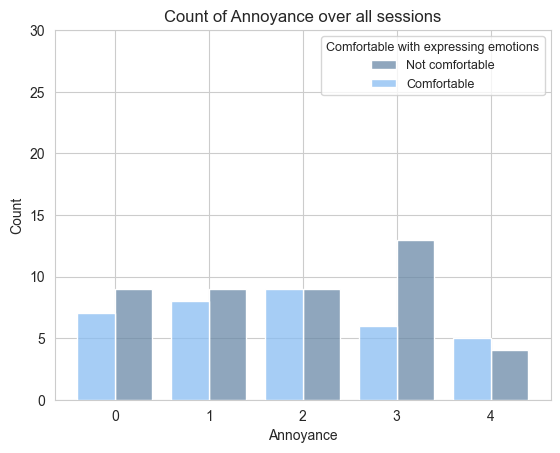

In [43]:
order = ['0', '1', '2', '3', '4', '5']
to_plot['Annoyance'] = pd.Categorical(to_plot['Annoyance'], categories=order, ordered=True)

ax = sns.histplot(data=to_plot, x='Annoyance', hue='Comfortable with expressing emotions', multiple="dodge", palette=colors[1:3], shrink=0.8, zorder=3)
ax.set_title('Count of Annoyance over all sessions')
ax.set_xlabel('Annoyance')
ax.set_ylim(0, 30)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

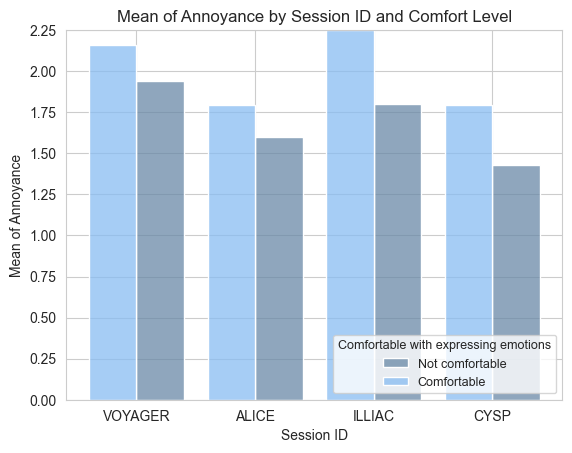

In [44]:
aggregated_data = grouped_df_all.groupby(['Session_ID', 'Comfortable with expressing emotions'], as_index=False)['Annoyance'].mean()

order = ['VOYAGER', 'ALICE', 'ILLIAC', 'CYSP']
aggregated_data['Session_ID'] = pd.Categorical(aggregated_data['Session_ID'], categories=order, ordered=True)

sns.set_style('whitegrid')
ax = sns.histplot(data=aggregated_data, x='Session_ID', weights='Annoyance', hue='Comfortable with expressing emotions', discrete=True, multiple='dodge', palette=colors[1:3], shrink=0.8)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'], loc='lower right')
ax.set_ylabel("Mean of Annoyance")
ax.set_xlabel("Session ID")
ax.set_title("Mean of Annoyance by Session ID and Comfort Level")
ax.set_ylim(0, 2.25)
plt.show()

/var/folders/np/z3d7fsz132vckb3gj8c2j2c00000gn/T/ipykernel_34310/383256663.py:40: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(


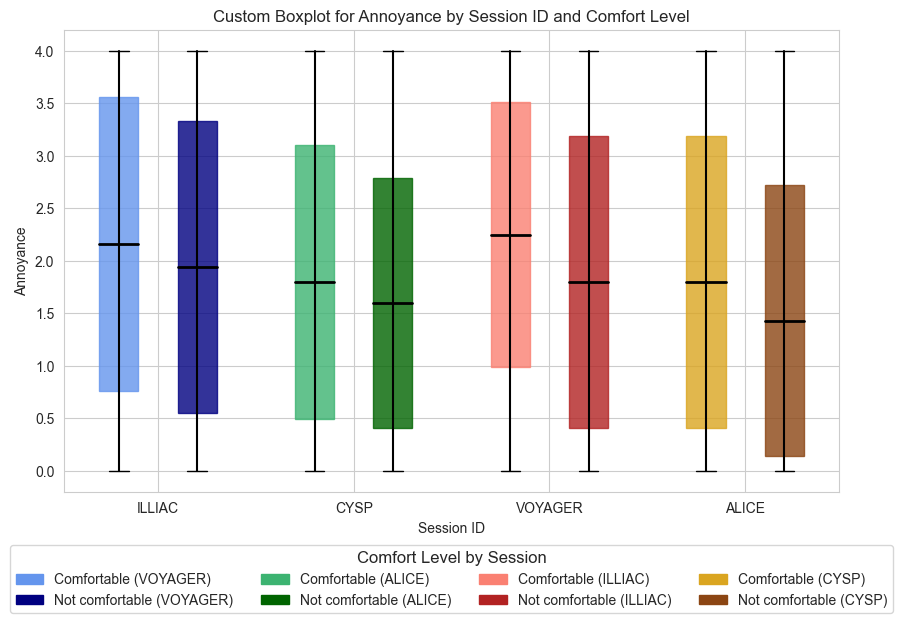

In [45]:
stats = grouped_df_all.groupby(['Session_ID', 'Comfortable with expressing emotions'])['Annoyance'].agg(
    mean='mean', std='std', min='min', max='max'
).reset_index()

stats['Session_ID'] = pd.Categorical(stats['Session_ID'], categories=order, ordered=True)
stats = stats.sort_values('Session_ID')

palette = {
    ('VOYAGER', 'Comfortable'): 'cornflowerblue',
    ('VOYAGER', 'Not comfortable'): 'navy',
    ('ALICE', 'Comfortable'): 'mediumseagreen',
    ('ALICE', 'Not comfortable'): 'darkgreen',
    ('ILLIAC', 'Comfortable'): 'salmon',
    ('ILLIAC', 'Not comfortable'): 'firebrick',
    ('CYSP', 'Comfortable'): 'goldenrod',
    ('CYSP', 'Not comfortable'): 'saddlebrown',
}

fig, ax = plt.subplots(figsize=(10, 6))

for idx, session in enumerate(stats['Session_ID'].unique()):
    for hue_idx, comfort in enumerate(stats['Comfortable with expressing emotions'].unique()):
        subset = stats[(stats['Session_ID'] == session) & (stats['Comfortable with expressing emotions'] == comfort)]
        if subset.empty:
            continue

        mean = subset["mean"].values[0]
        std = subset["std"].values[0]
        whisker_min = subset["min"].values[0]
        whisker_max = subset["max"].values[0]

        position = idx + (hue_idx - 0.5) * 0.4  # Adjust position for hue

        ax.plot([position, position], [whisker_min, whisker_max], color="black", lw=1.5)  # Whisker line
        ax.plot([position - 0.05, position + 0.05], [whisker_min, whisker_min], color="black", lw=1)  # Min cap
        ax.plot([position - 0.05, position + 0.05], [whisker_max, whisker_max], color="black", lw=1)  # Max cap

        box_bottom = mean - std
        box_top = mean + std
        ax.add_patch(plt.Rectangle(
            (position - 0.1, box_bottom),  # Bottom-left corner
            0.2,  # Box width
            2 * std,  # Box height
            color=palette[(session, comfort)],
            alpha=0.8,
            edgecolor="black"
        ))

        # Plot mean line
        ax.plot([position - 0.1, position + 0.1], [mean, mean], color='black', lw=2)  # Mean line

# Final adjustments
ax.set_xticks(range(len(grouped_df_all['Session_ID'].unique())))
ax.set_xticklabels(grouped_df_all['Session_ID'].unique())
ax.set_xlabel('Session ID')
ax.set_ylabel('Annoyance')
plt.title("Custom Boxplot for Annoyance by Session ID and Comfort Level")

legend_handles = [
    mpatches.Patch(color='cornflowerblue', label='Comfortable (VOYAGER)'),
    mpatches.Patch(color='navy', label='Not comfortable (VOYAGER)'),
    mpatches.Patch(color='mediumseagreen', label='Comfortable (ALICE)'),
    mpatches.Patch(color='darkgreen', label='Not comfortable (ALICE)'),
    mpatches.Patch(color='salmon', label='Comfortable (ILLIAC)'),
    mpatches.Patch(color='firebrick', label='Not comfortable (ILLIAC)'),
    mpatches.Patch(color='goldenrod', label='Comfortable (CYSP)'),
    mpatches.Patch(color='saddlebrown', label='Not comfortable (CYSP)')
]
ax.legend(handles=legend_handles, title='Comfort Level by Session',
          loc='upper center', ncol=4, fontsize=10, title_fontsize=12,
          bbox_to_anchor=(0.5, -0.1))
plt.show()

## ANOVA analysis

### During analysis

In [46]:
# Excitement - comparing sessions
result_non_comfortable = AnovaRM(data=non_comfortable, depvar='Excitement', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA on excitement for non-comfortable people:')
print(result_non_comfortable)

result_comfortable = AnovaRM(data=comfortable, depvar='Excitement', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA on excitement for comfortable people:')
print(result_comfortable)

result = AnovaRM(data=grouped_df_all, depvar='Excitement', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA on excitement for all people:')
print(result)

RM ANOVA on excitement for non-comfortable people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  2.8817 3.0000 102.0000 0.0395

RM ANOVA on excitement for comfortable people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  2.3590 3.0000 129.0000 0.0746

RM ANOVA on excitement for all people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  4.8727 3.0000 234.0000 0.0026



In [47]:
# Perform Tukey's HSD pairwise comparison
tukey_non_comfortable = pairwise_tukeyhsd(endog=non_comfortable['Excitement'], groups=non_comfortable['Session_ID'], alpha=0.05)
print('Tukey HSD on excitement for non-comfortable people:')
print(tukey_non_comfortable.summary())

tukey_all_excitement = pairwise_tukeyhsd(endog=grouped_df_all['Excitement'], groups=grouped_df_all['Session_ID'], alpha=0.05)
print('Tukey HSD on excitement for all people:')
print(tukey_all_excitement.summary())

tukey_all_excitement = pairwise_tukeyhsd(endog=grouped_df_all['Excitement'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print('Tukey HSD on excitement for all people grouping by comfortability with expressing emotions:')
print(tukey_all_excitement.summary())

Tukey HSD on excitement for non-comfortable people:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
 ALICE    CYSP  -0.1143 0.9734  -0.807 0.5784  False
 ALICE  ILLIAC     -0.2 0.8761 -0.8927 0.4927  False
 ALICE VOYAGER  -0.5429 0.1791 -1.2356 0.1499  False
  CYSP  ILLIAC  -0.0857 0.9884 -0.7784  0.607  False
  CYSP VOYAGER  -0.4286 0.3769 -1.1213 0.2641  False
ILLIAC VOYAGER  -0.3429 0.5725 -1.0356 0.3499  False
----------------------------------------------------
Tukey HSD on excitement for all people:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
 ALICE    CYSP  -0.1899 0.7338 -0.6675  0.2877  False
 ALICE  ILLIAC  -0.1392 0.8753 -0.6168  0.3383  False
 ALICE VOYAGER  -0.5063 0.0329 -0.9839 -0.0287   True
  CYSP  ILLIAC   0.0506 0.9928  -0.427  0.5282  False


In [48]:
# Annoyance - comparing sessions
result_non_comfortable = AnovaRM(data=non_comfortable, depvar='Annoyance', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA on annoyance for non-comfortable people:')
print(result_non_comfortable)

result_comfortable = AnovaRM(data=comfortable, depvar='Annoyance', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA on annoyance for comfortable people:')
print(result_comfortable)

result = AnovaRM(data=grouped_df_all, depvar='Annoyance', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA on annoyance for all people:')
print(result)

RM ANOVA on annoyance for non-comfortable people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  1.8623 3.0000 102.0000 0.1407

RM ANOVA on annoyance for comfortable people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  3.0336 3.0000 129.0000 0.0317

RM ANOVA on annoyance for all people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  4.5641 3.0000 234.0000 0.0040



In [49]:
# Perform Tukey's HSD on annoyance
tukey_comfortable = pairwise_tukeyhsd(endog=comfortable['Annoyance'], groups=comfortable['Session_ID'], alpha=0.05)
print('Tukey HSD on annoyance for comfortable people:')
print(tukey_comfortable.summary())

tukey_all = pairwise_tukeyhsd(endog=grouped_df_all['Annoyance'], groups=grouped_df_all['Session_ID'], alpha=0.05)
print('Tukey HSD on annoyance for all people:')
print(tukey_all.summary())

tukey = pairwise_tukeyhsd(endog=grouped_df_all['Annoyance'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print('Tukey HSD on annoyance for all people grouping by comfortability with expressing emotions:')
print(tukey.summary())

Tukey HSD on annoyance for comfortable people:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
 ALICE    CYSP      0.0    1.0 -0.7407 0.7407  False
 ALICE  ILLIAC   0.4545 0.3859 -0.2862 1.1952  False
 ALICE VOYAGER   0.3636 0.5809 -0.3771 1.1043  False
  CYSP  ILLIAC   0.4545 0.3859 -0.2862 1.1952  False
  CYSP VOYAGER   0.3636 0.5809 -0.3771 1.1043  False
ILLIAC VOYAGER  -0.0909 0.9888 -0.8316 0.6498  False
----------------------------------------------------
Tukey HSD on annoyance for all people:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
 ALICE    CYSP  -0.0759 0.9842 -0.6232 0.4713  False
 ALICE  ILLIAC   0.3418 0.3726 -0.2054  0.889  False
 ALICE VOYAGER   0.3544 0.3398 -0.1928 0.9016  False
  CYSP  ILLIAC   0.4177 0.2009 -0.1295 0.9649  False
  CYSP VOYAGE

### Post questions

In [50]:
# Control
data = grouped_df_all.rename(columns={'Comfortable with expressing emotions': 'Comfortability', 'Personal description': 'Description', 'Creative expression': 'Expression'})
model = ols('Control ~ C(Gender) + C(Description) + C(Comfortability) + C(Gender):C(Description) + C(Gender):C(Comfortability) + C(Description):C(Comfortability) + C(Gender):C(Description):C(Comfortability)', data=data).fit()
sm.stats.anova_lm(model, typ=2)


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Gender),5.824741,1.0,9.064111,0.002829
C(Description),0.673075,4.0,0.261850,0.852854
C(Comfortability),7.857839,1.0,12.227895,0.000542
C(Gender):C(Description),17.553018,4.0,6.828737,0.000183
C(Gender):C(Comfortability),1.908651,1.0,2.970128,0.085849
C(Description):C(Comfortability),2.344027,4.0,0.911908,0.435519
C(Gender):C(Description):C(Comfortability),20.711764,4.0,8.057600,0.000004
Residual,192.142125,299.0,NaN,NaN


In [51]:
# Creative expression
model_expression = ols('Expression ~ C(Gender) + C(Description) + C(Comfortability) + C(Gender):C(Description) + C(Gender):C(Comfortability) + C(Description):C(Comfortability) + C(Gender):C(Description):C(Comfortability)', data=data).fit()
sm.stats.anova_lm(model_expression, typ=2)

/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Gender),6.214468,1.0,4.824832,2.882003e-02
C(Description),15.988258,4.0,3.103269,2.695322e-02
C(Comfortability),0.303527,1.0,0.235655,6.277179e-01
C(Gender):C(Description),31.539457,4.0,6.121706,4.716893e-04
C(Gender):C(Comfortability),0.295104,1.0,0.229115,6.325308e-01
C(Description):C(Comfortability),23.710646,4.0,4.602159,3.637548e-03
C(Gender):C(Description):C(Comfortability),61.641395,4.0,11.964394,4.957251e-09
Residual,385.117216,299.0,NaN,NaN


## Notes from presentations


 * Heatmap could be a good supply?
 * Need to provide a confidence interval (ours is 95%)
 * Need much information about data to get a overview of the whole data set
 * ! Balance in the data !

# What are we doing?

Ihne:
 * Boxplots of annoyance and excitement
 * Boxplots of post questions